# Машинное обучение, DS-поток
## Задание ML.7


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 30 баллов;

In [1]:
# Bot check

# HW_ID: ds_ml7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [17]:
import copy
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.datasets import titanic

import lightgbm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

from xgboost import plot_tree as plot_xgb_tree
from lightgbm import plot_tree as plot_lgbm_tree
from sklearn.tree import plot_tree as plot_sklearn_tree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

---

### Задача 1

Рассмотрим данные из задачи ML.6.2. Задача заключается в сравнении моделей градиентного бустинга из sklearn, для которой категориальные признаки закодированы с помощью
* LabelEncoding,
* MeanEncoding.

Какие признаки будете рассматривать? Какие именно преобразования будете совершать?

Вспомним, какие признаки есть в датасете (скопируем ячейку из ML6)
Данные имеют следующие столбцы:
* `id` — идентификационный номер жилья
* `date` — дата продажи дома
* `price` — цена
* `bedrooms` — количество спален
* `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* `sqft_living` — площадь жилья
* `sqft_lot` — площадь участка
* `floors` — количество этажей
* `waterfront` — видна ли набережная
* `view` — насколько хороший вид
* `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
* `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
* `sqft_above` — жилая площадь над уровнем земли
* `sqft_basement` — жилая площадь под уровнем земли
* `yr_built` — год постройки жилья
* `yr_renovated` — год последней реконструкции жилья
* `zipcode` — почтовый индекс
* `lat` — широта
* `long` — долгота
* `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
* `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

Вспомним, что в тот раз было полезно выкинуть признак `id`, поскольку одно и то же жилье может быть продано несколько раз в разное время по разной цене с одинаковыми остальными признаками. Кроме того, чтобы нормально обработать `date`, заменим столбец с ней на время с момента продажи до текущего. Также можно пошаманить немного над столбцом `bathrooms`. Ну и разобьем город на районы, сетка 10*10

Загрузим наши данные:

In [3]:
train = pd.read_csv('houses_train.csv')
test = pd.read_csv('houses_test.csv')
train = train.drop_duplicates(subset='id')
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20151013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20151209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20151209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,20160218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,20150627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


Выполните базовую предобработку данных из задачи ML.6.2

*Совет.* Используйте код из своего решения предыдущего домашнего задания и/или код с семинаров.

Переводим дату в валидный формат:

In [4]:
train['date'] = pd.to_datetime(train['date'], format='%Y%m%dT%H%M%S')
train['date'] = (pd.Timestamp.now() - train['date']).dt.days
test['date'] = pd.to_datetime(test['date'], format='%Y%m%dT%H%M%S')
test['date'] = (pd.Timestamp.now() - test['date']).dt.days
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3300,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3243,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,3243,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,3172,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,3408,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


Так же разобьем `bathrooms` на целую часть и на наличие/отсутствие дробной части:

In [5]:
train['has_fractional_part'] = train['bathrooms'] % 1 > 0
train['bathrooms'] = train['bathrooms'].floordiv(1)
test['has_fractional_part'] = test['bathrooms'] % 1 > 0
test['bathrooms'] = test['bathrooms'].floordiv(1)
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_fractional_part
0,3300,221900.0,3,1.0,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,False
1,3243,538000.0,3,2.0,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,True
2,3243,604000.0,4,3.0,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,False
3,3172,510000.0,3,2.0,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,False
4,3408,257500.0,3,2.0,1715,6819,2.0,0,0,3,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,True


Выполните обработку категориальных признаков

В данных нет явных категориальных признаков имеющих строковых вид, однако таким являются признаки `zipcode` и `zone`. Все остальные признаки в нашем случае являются вещественными.

In [7]:
real_features = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']
cat_features = ['zipcode']

Разбиваем на тренировочную и валидационную выборки:

In [8]:
X_train_encoder, X_val_encoder, y_train, y_val = train_test_split(
    train.drop(columns='price'), 
    train['price'], test_size=0.2
)

В наших данных нет как таковых пропусков, иначе в тот раз XGBoost и LightGBM на нас матерились бы, значит просто сделаем две копии данных-с сырыми категориальными признаками и с обработанными `MeanEncoder`

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class MeanEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, target_type='binary', 
                 encoding='likelihood', func=None):
        if target_type == 'continuous' and encoding in ['woe', 'diff']:
            raise ValueError(
                '{} target_type can\'t be used with {} encoding'.format(
                    target_type, encoding
                )
            )
        self.target_type = target_type
        self.encoding = encoding
        self.func = func
    
    def goods(self, x):
        return np.sum(x == 1)
    
    def bads(self, x):
        return np.sum(x == 0)
    
    def encode(self, X, y, agg_func):
        self.means = dict()
        self.global_mean = np.nan
        X['target'] = y
        for col in X.columns:
            if col != 'target':
                col_means = X.groupby(col)['target'].agg(agg_func)
                self.means[col] = col_means
        X.drop(['target'], axis=1, inplace = True)
        
    def fit(self, X, y):
        if self.encoding == 'woe':
            self.encode(
                X, y, 
                lambda x: np.log(self.goods(x) / self.bads(x)) * 100
            )
            self.global_mean = np.log(self.goods(y) / self.bads(y)) * 100
        elif self.encoding == 'diff':
            self.encode(X, y, lambda x: self.goods(x) - self.bads(x))
            self.global_mean = self.goods(y) - self.bads(y)
        elif self.encoding == 'likelihood':
            self.encode(X, y, np.mean)
            self.global_mean = np.mean(y)
        elif self.encoding == 'count':
            self.encode(X, y, np.sum)
            self.global_mean = np.sum(y)
        elif self.encoding == 'function':
            self.encode(X, y, lambda x: self.func(x))
            self.global_mean = self.func(y)
        return self
    
    def transform(self, X):
        X_new = pd.DataFrame()
        for col in X.columns:
            X_new[col] = X[col].map(self.means[col]).fillna(self.global_mean)
        return X_new
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [10]:
X_train_encoder[cat_features] = X_train_encoder[cat_features].astype(str)
X_val_encoder[cat_features] = X_val_encoder[cat_features].astype(str)
X_train_origin = X_train_encoder.copy()
X_val_origin = X_val_encoder.copy()
encoder = MeanEncoder()
X_train_origin[cat_features] = encoder.fit_transform(X_train_origin[cat_features], 
                                               y_train)
X_val_encoder[cat_features] = encoder.transform(X_val_encoder[cat_features])
X_train_encoder = X_train_origin.copy()
X_val_encoder = X_val_encoder.copy()

/tmp/ipykernel_343012/3370632665.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['target'] = y
/tmp/ipykernel_343012/3370632665.py:30: FutureWarning: The provided callable <function mean at 0x7fb0900e1c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  col_means = X.groupby(col)['target'].agg(agg_func)
/tmp/ipykernel_343012/3370632665.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['target'], axis=1, inplace = True)


In [11]:
X_val_encoder.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_fractional_part,zone
13659,3096,4,2.0,2210,5572,1.5,0,3,3,7,...,450,1911,0,402670.715789,47.5727,-122.376,1760,4713,False,15
9987,3177,4,3.0,2580,9601,2.0,0,0,4,7,...,450,1992,0,459271.521739,47.3726,-122.433,1900,10092,False,5
3545,3331,4,3.0,3780,20023,2.0,0,2,3,10,...,0,2001,0,605835.973545,47.5491,-122.006,2150,3675,True,17
4189,3291,3,2.0,2780,5467,2.0,0,2,3,9,...,0,2000,0,402670.715789,47.5791,-122.378,2630,5000,True,15
3314,3107,3,1.0,1030,15264,1.0,0,0,4,7,...,0,1962,0,414625.542601,47.5016,-122.168,1430,14840,False,11


Обучите модели и постройте зависимость значения MAPE от количества деревьев и их максимальной глубины.

Скопируем наш код с прошлой домашки и немного его модифицируем:

In [12]:
def get_train_and_test_mape(model_name, param_name, grid, other_params_dict={}):
    '''
    Функция для оценки точности классификации градиентным бустингом
    для заданных значений параметра param_name
    
    Параметры:
    1) model_name - название модели
    2) param_name — название параметра, который собираемся варьировать,
    3) grid — сетка значений параметра,
    4) other_params_dict — словарь со значениями остальных параметров.
    '''
        
    train_res, val_res = [], []
    params_dict = copy.copy(other_params_dict)
    if model_name == 'CatBoost':
        value = params_dict['lambda']
        params_dict.pop('alpha')
        params_dict.pop('lambda')
        params_dict['l2_leaf_reg'] = value
        if (param_name == 'lambda'):
            param_name = 'l2_leaf_reg'

    if model_name == 'Sklearn':
        params_dict.pop('lambda')

    for param_value in grid:
        params_dict.update({param_name: param_value})
        if model_name == 'CatBoost':
            estimator = CatBoostRegressor(**params_dict, thread_count=-1, verbose=0, random_state=42, cat_features=cat_features, task_type='GPU')
            estimator.fit(X_train_origin, y_train)
            train_res.append(mean_absolute_percentage_error(y_train, estimator.predict(X_train_origin)))
            val_res.append(mean_absolute_percentage_error(y_val, estimator.predict(X_val_origin)))
        else:
            if model_name == 'XGBoost':
                estimator = XGBRegressor(**params_dict, n_jobs=-1, random_state=42)
            if model_name == 'LightGBM':
                estimator = lightgbm.LGBMRegressor(**params_dict, n_jobs=-1, verbose=-1, random_state=42)
            if model_name == 'Sklearn':
                estimator = GradientBoostingRegressor(**params_dict, random_state=42)
            estimator.fit(X_train_encoder, y_train)
            train_res.append(mean_absolute_percentage_error(y_train, estimator.predict(X_train_encoder)))
            val_res.append(mean_absolute_percentage_error(y_val, estimator.predict(X_val_encoder)))
        
    return train_res, val_res

def plot_dependence(
    param_name, grid=range(2, 20), model_names={},
    other_params_dict={}, title='', ylim=(0, 0.4)
):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name — название параметра, который собираемся варьировать,
    2) grid — сетка значений параметра,
    3) other_params_dict — словарь со значениями остальных параметров,
    4) title — заголовок графика.
    '''
    
    plt.figure(figsize=(16, 9))
    colors = ['green', 'red', 'orange', 'blue']
    for i in range(len(model_names)):
      train_mape, test_mape = get_train_and_test_mape(
        model_names[i], param_name, grid, other_params_dict
      )
      plt.plot(grid, train_mape, label=model_names[i]+'(train)', linestyle='--', color=colors[i])
      plt.plot(grid, test_mape, label=model_names[i]+'(val)', color=colors[i])
      print(f'Для {model_names[i]} минимум на валидации {test_mape[np.argmin(test_mape)]:.4f} при значении {grid[np.argmin(test_mape)]:.4f}')
    if (param_name in ['n_estimators', 'alpha', 'lambda', 'learning_rate']):
        plt.xscale('log')
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('MAPE')
    plt.ylim(ylim)
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

Для XGBoost минимум на валидации 0.1193 при значении 7.0000
Для CatBoost минимум на валидации 0.1164 при значении 10.0000
Для LightGBM минимум на валидации 0.1191 при значении 15.0000
Для Sklearn минимум на валидации 0.1190 при значении 5.0000


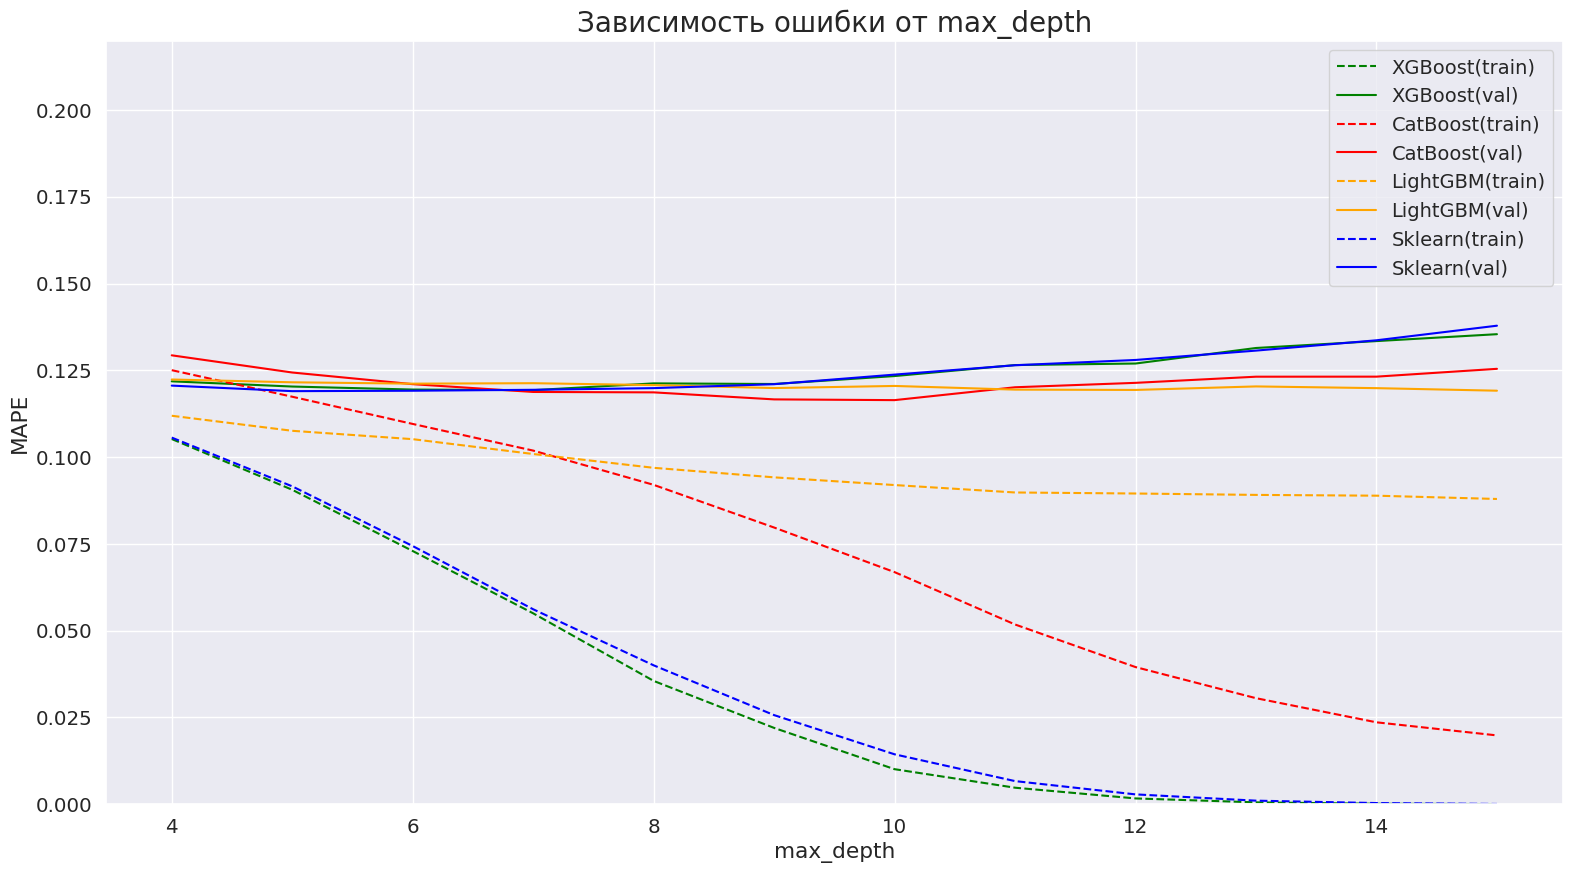

In [13]:
other_params = {
    'n_estimators' : 300,
    'learning_rate' : 0.1,
    'alpha' : 0.1,
    'lambda' : 0.1,
    'max_depth' : 7
}

model_names = ['XGBoost', 'CatBoost', 'LightGBM', 'Sklearn']

plot_dependence(
    'max_depth', range(4, 16, 1), model_names, other_params,
    title='Зависимость ошибки от max_depth', ylim=(0, 0.22)
)

Для XGBoost минимум на валидации 0.1193 при значении 300.0000
Для CatBoost минимум на валидации 0.1188 при значении 300.0000
Для LightGBM минимум на валидации 0.1208 при значении 500.0000
Для Sklearn минимум на валидации 0.1194 при значении 300.0000


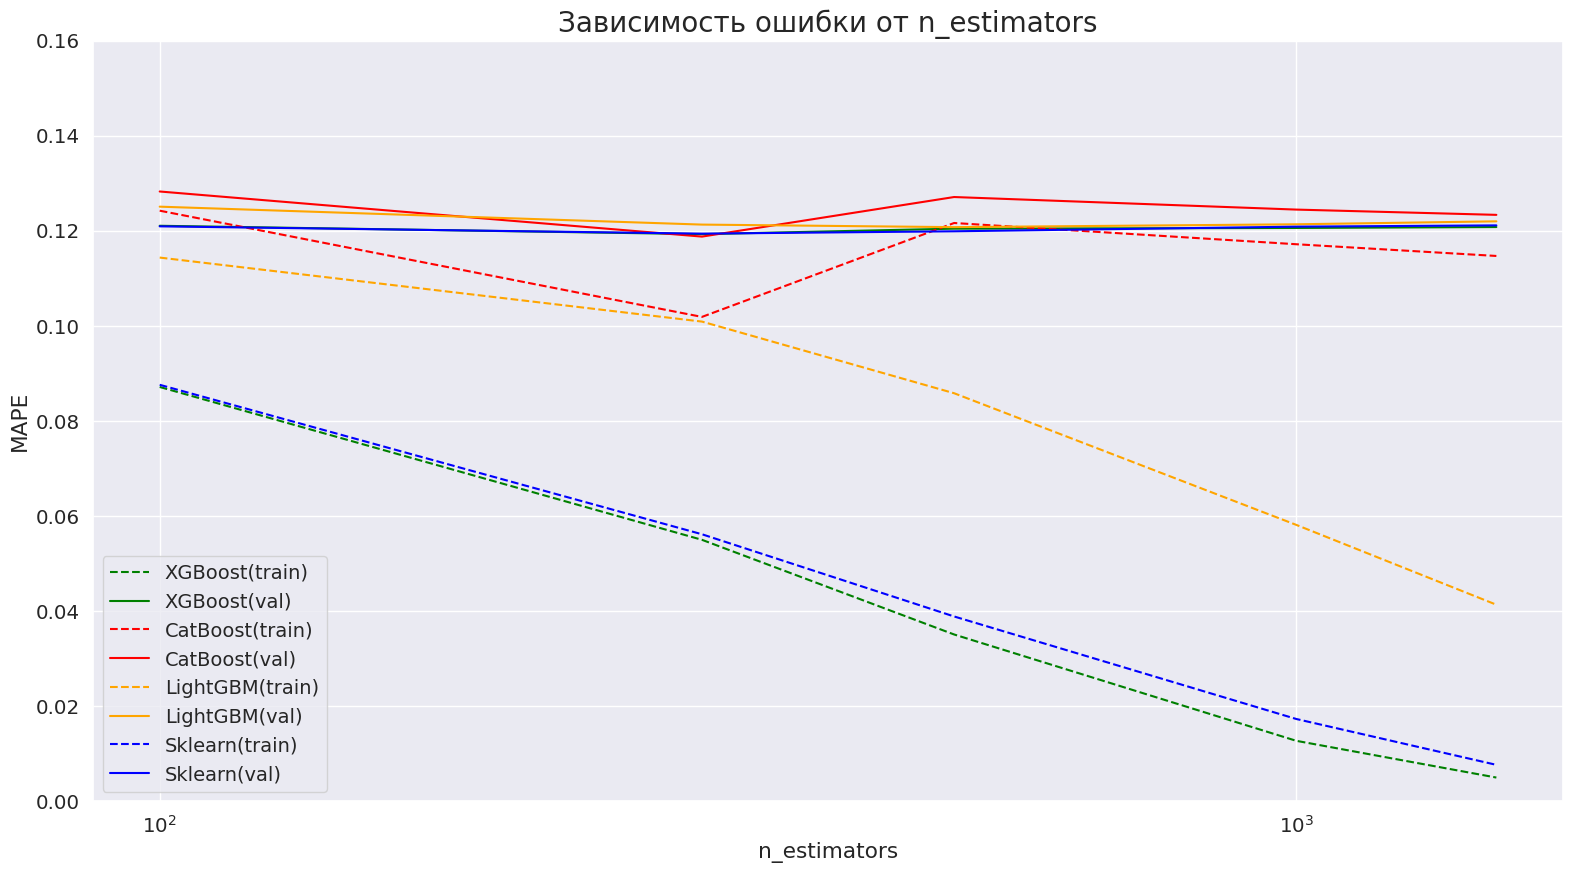

In [15]:
plot_dependence(
    'n_estimators', [100, 300, 500, 1000, 1500], model_names, other_params,
    title='Зависимость ошибки от n_estimators', ylim=(0, 0.16)
)

Видно, что все методы стали работать чуть лучше, но больше всех похорошел XGBoost и вырвался в безоговорочные лидеры. Ради интереса, получим предсказания и зашлем их в Kaggle:

In [45]:
grid_xgb = {
    'n_estimators' : [200, 250, 300, 350, 400, 450],
    'max_depth' : range(3, 11),
    'eta' : np.logspace(-5, -0.01, 20),
    'lambda' : np.logspace(-5, -0.01, 20),
    'alpha' : np.logspace(-5, -0.01, 20)
}

xgb_model = XGBRegressor()
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=None)

xgb_gs = RandomizedSearchCV(
    estimator=xgb_model,
    n_iter=200,
    param_distributions=grid_xgb,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=10,  
    cv=ss,
    verbose=10,
    error_score='raise',
    random_state=42
)

xgb_gs.fit(X_train_encoder, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 4/5; 1/200] START alpha=0.0003765212342787195, eta=0.0006893202750501534, lambda=1e-05, max_depth=9, n_estimators=300[CV 1/5; 1/200] START alpha=0.0003765212342787195, eta=0.0006893202750501534, lambda=1e-05, max_depth=9, n_estimators=300

[CV 2/5; 1/200] START alpha=0.0003765212342787195, eta=0.0006893202750501534, lambda=1e-05, max_depth=9, n_estimators=300
[CV 5/5; 1/200] START alpha=0.0003765212342787195, eta=0.0006893202750501534, lambda=1e-05, max_depth=9, n_estimators=300
[CV 1/5; 2/200] START alpha=0.0006893202750501534, eta=0.014176823986277055, lambda=0.9772372209558107, max_depth=8, n_estimators=450
[CV 4/5; 2/200] START alpha=0.0006893202750501534, eta=0.014176823986277055, lambda=0.9772372209558107, max_depth=8, n_estimators=450
[CV 2/5; 2/200] START alpha=0.0006893202750501534, eta=0.014176823986277055, lambda=0.9772372209558107, max_depth=8, n_estimators=450
[CV 3/5; 1/200] START alpha=0.0003765212342787

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None),
                   error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          g...
       1.12337904e-04, 2.05663818e-04, 3.76521234e-04, 6.89320275e-04,
       1.26198046e-03, 2.31038422e-03, 4.22976062e-03, 7.74367947e-03,
       1.41768240e-02, 2.59543721e-02, 4.75162442e-02, 8.69908720e-02,
       1.59259469e-01, 2.91565975e-01, 5.33787527e-01, 9.77237221e-01]),
                                        'max_depth': range(3, 11),
                                        'n_estimators': [200, 250, 300, 350,
                                                         400, 450]},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error', verbose=10)

In [46]:
xgb_gs.best_params_

{'n_estimators': 350,
 'max_depth': 6,
 'lambda': 0.15925946892003542,
 'eta': 0.08699087199195209,
 'alpha': 0.9772372209558107}

In [47]:
gs_params = {'n_estimators': 350,
             'max_depth': 6,
             'lambda': 0.15925946892003542,
             'eta': 0.08699087199195209,
             'alpha': 0.9772372209558107}
best_gs_xgb = XGBRegressor(**gs_params, n_jobs=-1)
best_gs_xgb.fit(X_train_encoder, y_train)
mean_absolute_percentage_error(best_gs_xgb.predict(X_val_encoder), y_val)

0.11426995256565156

In [48]:
test[cat_features] = test[cat_features].astype(str)
test[cat_features] = encoder.transform(test[cat_features])
pred = best_gs_xgb.predict(test.values)
df = pd.DataFrame(pred, columns=['price'])
df.index += 1
df.to_csv("predictions_old.csv", sep=",", index_label='index')

Получили MAPE на приватных данных аж 11.7! Очень хорошо по сравнению со всеми прошлыми посылками.

Теперь переформатируем данные с LabelEncoding и посмотрим что получится:

In [21]:
X = train.drop(columns='price')
y = train['price']

X_train_encoder, X_val_encoder, y_train, y_val = train_test_split(X, y, random_state=1337)

X_train_encoder[cat_features] = X_train_encoder[cat_features].astype(str)
X_val_encoder[cat_features] = X_val_encoder[cat_features].astype(str)
X_train_origin = X_train_encoder.copy()
X_val_origin = X_val_encoder.copy()

for feature in cat_features:
    encoder = LabelEncoder()
    encoder.fit(X_train_encoder[[feature]])
    X_train_encoder[feature] = encoder.transform(X_train_encoder[[feature]]).astype(int)
    X_val_encoder[feature] = encoder.transform(X_val_encoder[[feature]]).astype(int)

X_train_encoder

/home/roman/HW/myenv2/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/roman/HW/myenv2/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/roman/HW/myenv2/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_fractional_part,zone
9797,3300,3,1.0,960,5700,1.0,0,0,4,5,...,0,1956,0,31,47.4983,-122.172,960,5700,False,11
6907,3157,3,1.0,1550,7200,1.0,0,0,3,7,...,450,1949,0,55,47.7071,-122.314,1560,7440,True,20
6772,3447,4,1.0,1310,8250,1.0,0,0,3,7,...,250,1953,0,61,47.4250,-122.332,1260,8255,True,10
333,3250,3,1.0,1920,9102,1.0,0,0,3,7,...,0,1968,0,36,47.7487,-122.082,1920,9760,True,21
4811,3383,4,2.0,1560,7569,1.5,0,0,4,7,...,0,1966,0,32,47.4496,-122.155,1480,8755,False,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,3089,5,2.0,2510,35691,1.0,0,0,3,9,...,0,1967,0,4,47.6435,-122.154,3160,35037,True,16
9566,3208,2,1.0,670,6300,1.0,0,0,4,6,...,0,1942,0,56,47.5145,-122.374,740,6300,False,10
870,3237,4,1.0,1440,8250,1.0,0,0,3,7,...,0,1959,0,67,47.4325,-122.291,1440,8466,False,10
8484,3269,3,1.0,1320,7201,1.0,0,0,3,7,...,0,1971,0,22,47.7126,-122.211,1380,7201,True,21


Для XGBoost минимум на валидации 0.1213 при значении 6.0000
Для CatBoost минимум на валидации 0.1203 при значении 11.0000
Для LightGBM минимум на валидации 0.1218 при значении 14.0000
Для Sklearn минимум на валидации 0.1221 при значении 7.0000


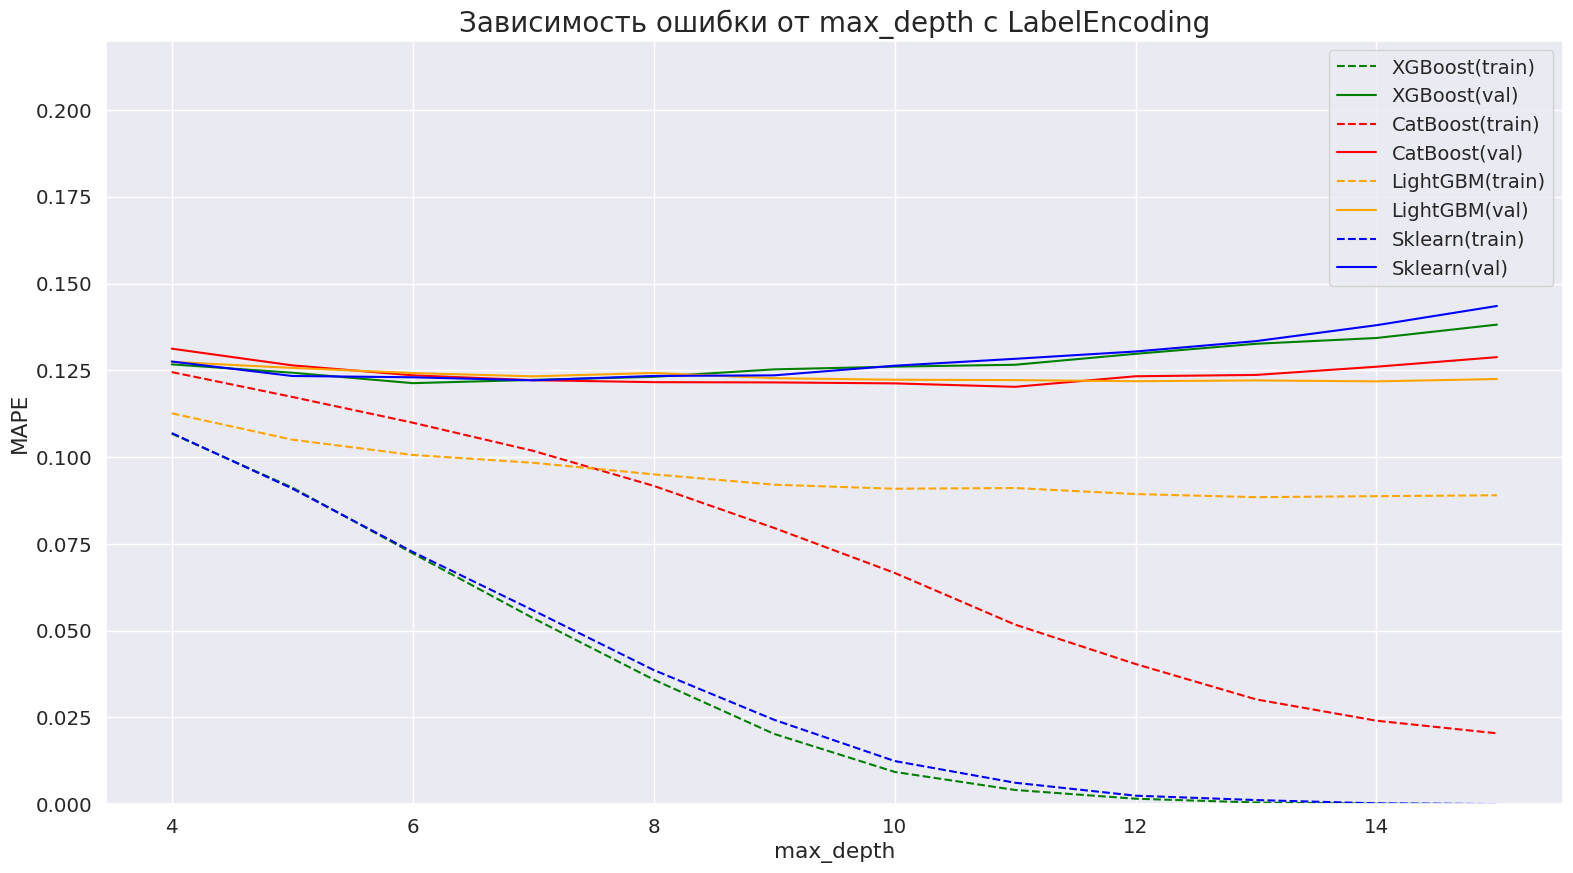

In [23]:
plot_dependence(
    'max_depth', range(4, 16, 1), model_names, other_params,
    title='Зависимость ошибки от max_depth с LabelEncoding', ylim=(0, 0.22)
)

Для XGBoost минимум на валидации 0.1222 при значении 300.0000
Для CatBoost минимум на валидации 0.1222 при значении 300.0000
Для LightGBM минимум на валидации 0.1215 при значении 1000.0000
Для Sklearn минимум на валидации 0.1221 при значении 300.0000


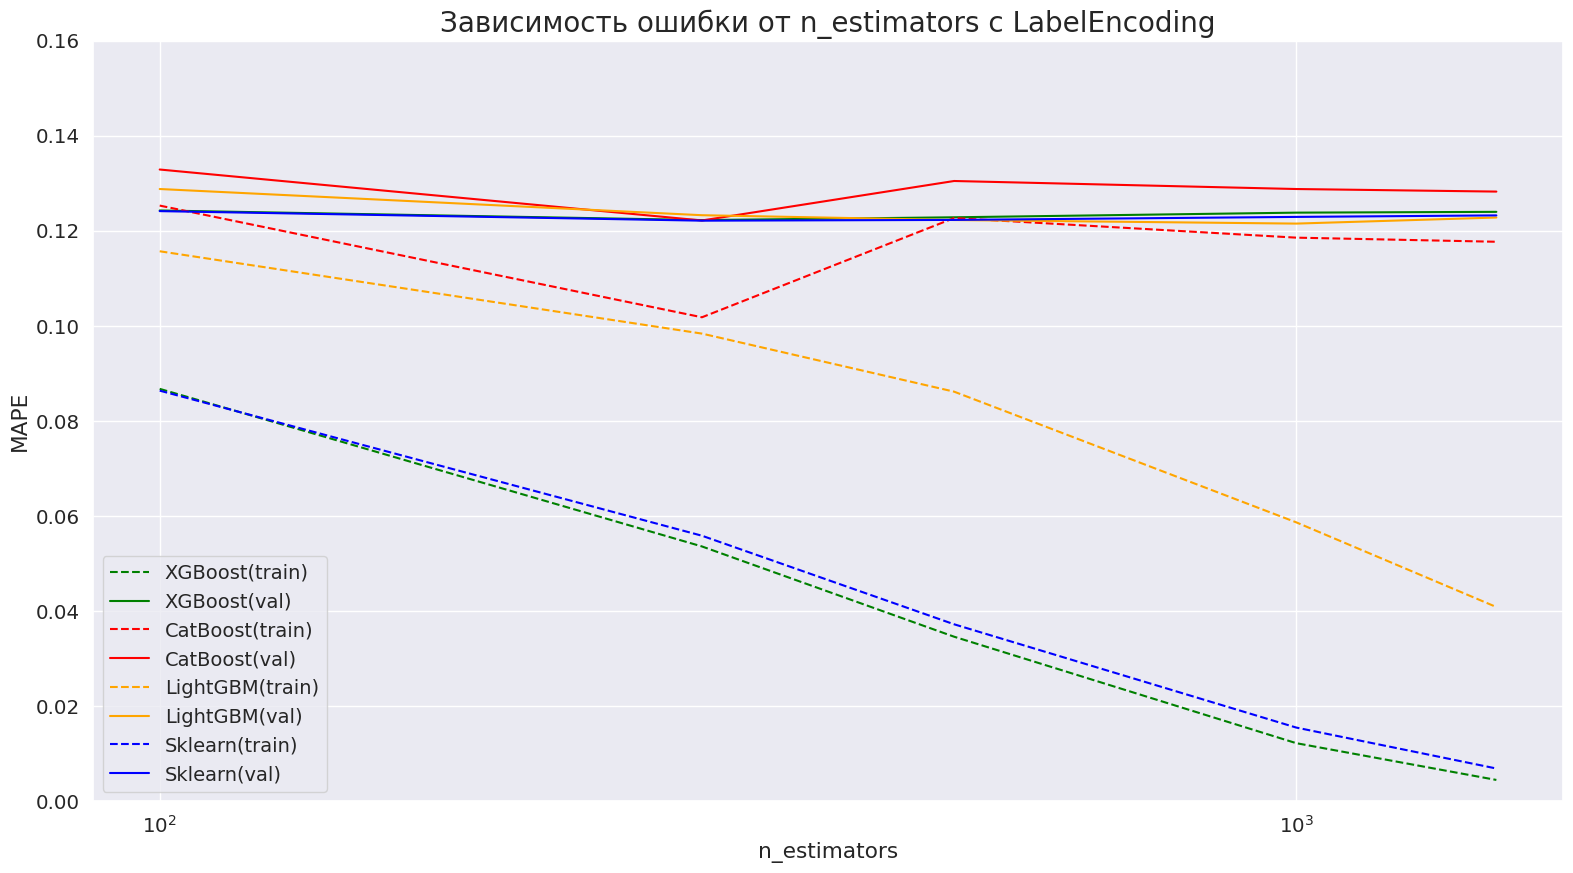

In [24]:
plot_dependence(
    'n_estimators', [100, 300, 500, 1000, 1500], model_names, other_params,
    title='Зависимость ошибки от n_estimators с LabelEncoding', ylim=(0, 0.16)
)

**Выводы:** Можно сделать вывод, что при небольшом количестве категориальных признаков (в нашем случае 1) зависимость качества от `max_depth` и `n_estimators` остается примерно таким же и для `MeanEncoder`, и для `LabelEncoder`. Можно так же сделать вывод, что `MeanEncoder` работает просто прекрасно в данном случае, посылка улучшилась с 20 до 8 места на приватных данных. Значит категориальные признаки по типу `zipcode` не стоит выбрасывать, а стоит обрабатывать хотя бы самым тупым способом.